### Predictive Maintenance - Liveline Technologies

Goal: Predict potential failures or deviations in machine performance using process variables (such as temperature, raw material properties, etc.). This can help prevent downtime and improve machine efficiency.

#### Dataset

In the dataset, there are 116 columns and 14088 rows. 

The data comes from a continuous flow manufacturing process with multiple stages. Sample rates are 1 Hz.

* In the first stage, Machines 1, 2, and 3 operate in parallel, and feed their outputs into a step that combines the flows.
* Output from the combiner is measured in 15 locations. These measurements are the primary measurements to predict.
* Next, the output flows into a second stage, where Machines 4 and 5 process in series.
* Measurements are made again in the same 15 locations. These are the secondary measurements to predict.

Here is the variable summary:

* Factory ambient Conditions (Humidity & Temperature) (Uncontrolled)
* Machine 1, 2, & 3:
    + Raw Material properties (1-5)
    + Zone 1 & Zone 2 Temperatures
    + Process Variables (Motor Amperage, Motor RPM, Material Pressure, Material Temperature, Exit Zone Temperature)
* Combiner stage process parameters (Temperature 1(Uncontrolled), 2(Uncontrolled) & 3(Controlled))
* Stage 1 output measurements (0-14) (actual & setpoint)
* Machine 4 & 5:
    + Controlled Temperature 1 & 2
    + Controlled Pressure
    + Controlled Temperature 3, 4, 5 & Exit
* Stage 2 output measurements (0-14) (actual & setpoint)





In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

In [2]:
# Read the dataset
data = pd.read_csv("continuous_factory_process.csv")

data.head()

,time_stamp,AmbientConditions.AmbientHumidity.U.Actual,AmbientConditions.AmbientTemperature.U.Actual,Machine1.RawMaterial.Property1,Machine1.RawMaterial.Property2,Machine1.RawMaterial.Property3,Machine1.RawMaterial.Property4,Machine1.RawMaterialFeederParameter.U.Actual,Machine1.Zone1Temperature.C.Actual,Machine1.Zone2Temperature.C.Actual,...,Stage2.Output.Measurement10.U.Actual,Stage2.Output.Measurement10.U.Setpoint,Stage2.Output.Measurement11.U.Actual,Stage2.Output.Measurement11.U.Setpoint,Stage2.Output.Measurement12.U.Actual,Stage2.Output.Measurement12.U.Setpoint,Stage2.Output.Measurement13.U.Actual,Stage2.Output.Measurement13.U.Setpoint,Stage2.Output.Measurement14.U.Actual,Stage2.Output.Measurement14.U.Setpoint
0,2019-03-06 10:52:33,17.24,23.53,11.54,200,963.0,247,1241.26,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
1,2019-03-06 10:52:34,17.24,23.53,11.54,200,963.0,247,1246.09,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
2,2019-03-06 10:52:35,17.24,23.53,11.54,200,963.0,247,1246.29,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
3,2019-03-06 10:52:36,17.24,23.53,11.54,200,963.0,247,1247.59,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
4,2019-03-06 10:52:37,17.24,23.53,11.54,200,963.0,247,1252.83,72.1,72.4,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71


### Data Processing

Let's explore the data a bit. First, I'll check for missing values and basic information about the dataset.

In [3]:
# Checking for missing values
missing_values = data.isnull().sum()
missing_values[missing_values>0]

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14088 entries, 0 to 14087
Columns: 116 entries, time_stamp to Stage2.Output.Measurement14.U.Setpoint
dtypes: float64(108), int64(7), object(1)
memory usage: 12.5+ MB


No missing values, that's great news!
Now, since it is a time-series data, we need to check whether the process time records are sequential and at regular intervals. If not, we will ensure that they are sequentially sorted at regular gaps.

In [4]:
# Sort the data based on the time_stamp
data['time_stamp'] = pd.to_datetime(data['time_stamp'])
data=data.sort_values(by='time_stamp').reset_index(drop=True)

# Calculate whether there is a time difference
time_diffs = data['time_stamp'].diff()
unique_time_diffs = time_diffs.unique()
time_diff_freq = time_diffs.value_counts()
print(f"Unique time difference: {unique_time_diffs}")
print(time_diff_freq)

Unique time difference: <TimedeltaArray>
[NaT, '0 days 00:00:01', '0 days 00:00:00', '0 days 00:00:02']
Length: 4, dtype: timedelta64[ns]
time_stamp
0 days 00:00:01    14059
0 days 00:00:00       14
0 days 00:00:02       14
Name: count, dtype: int64


From above, we see that 1-second interval represents majority of the data.
Whereas, there are 14 occurrences of 0 & 2 seconds which is unexpected and should be treated to perform time-series analysis later.

We will move forward with the following assumptions:
+ 0 second of time difference could indicate that the machine recorded multiple measurements at the same moment. For this difference, we will take average of the duplicate values.
+ 2 seconds of time difference could indicate that the time_stamp between these rows is missing. For this difference, we will resample the data to a uniform 1-second interval and fill the missing values using interpolation based on the values immediately before and after.

In [5]:
# Aggregate duplicate timestamps by taking the mean of their values
data_no_duplicates = data.groupby('time_stamp').mean().reset_index()

In [6]:
# Set the time_stamp column as the index
data_no_duplicates.set_index('time_stamp', inplace=True)

# Resample data to 1-second intervals
resampled_data = data_no_duplicates.resample('1s').mean()

# Interpolate missing values
resampled_data = resampled_data.interpolate(method='linear')


There are some uneven values in setpoint column, we will make them consistent as well.

In [7]:
# Identify Setpoint columns
setpoint_cols = [col for col in resampled_data.columns if 'Setpoint' in col]

# Ensure setpoint values are fixed for each feature by calculating the mode
for col in setpoint_cols:
    most_common_value = resampled_data[col].mode()[0]
    resampled_data[col] = most_common_value

Let's check if the data is processed as planned.

In [8]:
# Calculate whether there is a time difference in the resampled data
time_diffs_re = resampled_data.index.to_series().diff()
unique_time_diffs_re = time_diffs_re.unique()
time_diff_freq_re = time_diffs_re.value_counts()
print(f"Unique time difference: {unique_time_diffs_re}")
print(time_diff_freq_re)

Unique time difference: <TimedeltaArray>
[NaT, '0 days 00:00:01']
Length: 2, dtype: timedelta64[ns]
time_stamp
0 days 00:00:01    14087
Name: count, dtype: int64


Data processing done.

### Exploratory Data Analysis

Now, let's create some visualizations to see what's up with the manufacturing process.

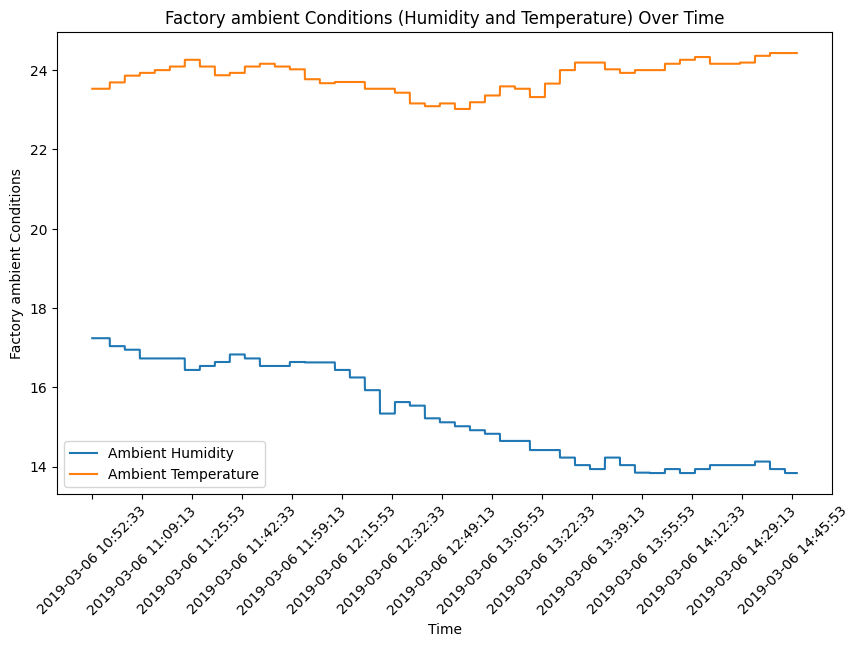

In [9]:
# Visualize factory ambient conditions

# I know it's not ideal to have them on the same plot but here we just want to explore the trends and these plots should give a decent idea.
# Plot Ambient Humidity and Temperature over time
plt.figure(figsize=(10,6))
plt.plot(resampled_data.index, resampled_data['AmbientConditions.AmbientHumidity.U.Actual'], label='Ambient Humidity')
plt.plot(resampled_data.index, resampled_data['AmbientConditions.AmbientTemperature.U.Actual'], label='Ambient Temperature')
plt.xlabel('Time')
plt.ylabel('Factory ambient Conditions')
plt.title('Factory ambient Conditions (Humidity and Temperature) Over Time')
plt.legend()
plt.xticks(ticks=resampled_data.index[::1000], labels=resampled_data.index[::1000],rotation=45)
plt.show()


From the above plot, we see that the ambient humidty has downward trend towards the end and temperature has dip in the between. Interesting! One would think, this would stay consistent throughout the process but manufacturing can have several uncontrolled parameters that can have an impact on the resulting parameters.

Since there are three machines running in parallel, let's go through the properties related to one of the three machines'.

Naturally, I chose machine 1. Let's look at different raw materials' proprties trends. (I know it's not ideal to put these different material properties on the same graph, but since we just want to look at the trends, it should serve our purpose.)

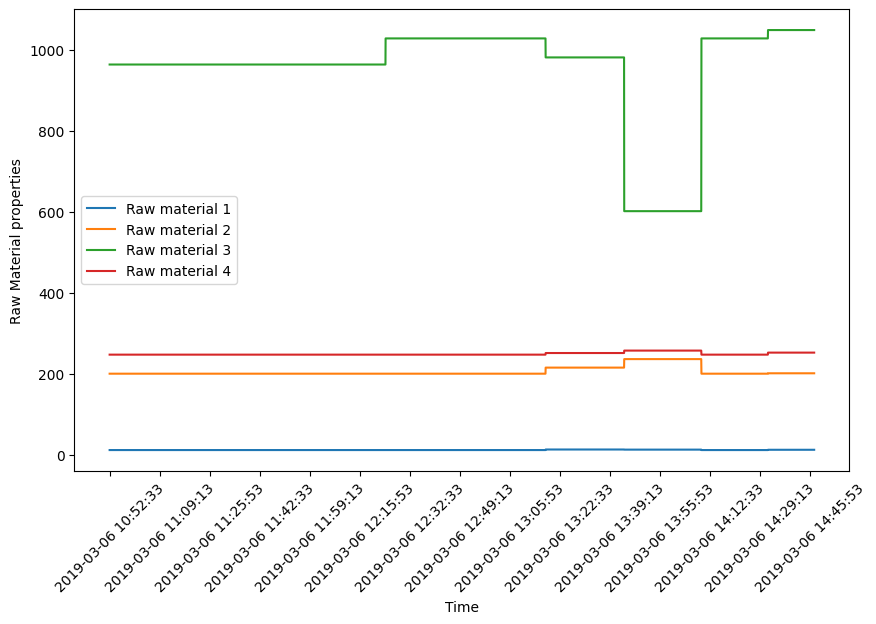

In [10]:
# Machine 1 raw material properties
plt.figure(figsize=(10,6))
plt.plot(resampled_data.index, resampled_data['Machine1.RawMaterial.Property1'], label = 'Raw material 1')
plt.plot(resampled_data.index, resampled_data['Machine1.RawMaterial.Property2'], label = 'Raw material 2')
plt.plot(resampled_data.index, resampled_data['Machine1.RawMaterial.Property3'], label = 'Raw material 3')
plt.plot(resampled_data.index, resampled_data['Machine1.RawMaterial.Property4'], label = 'Raw material 4')
plt.xlabel("Time")
plt.ylabel('Raw Material properties')
plt.xticks(ticks=resampled_data.index[::1000], labels=resampled_data.index[::1000], rotation=45)
plt.legend()
plt.show()

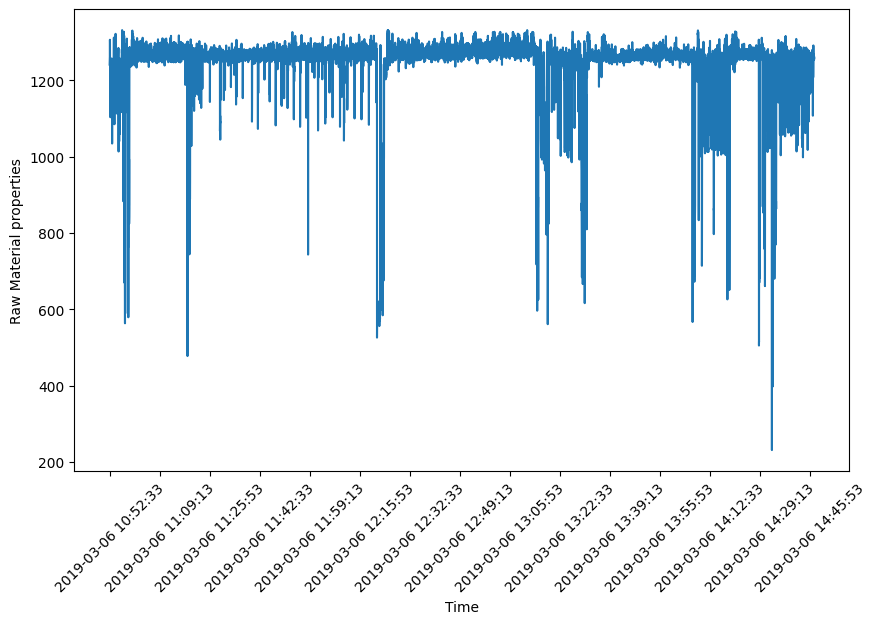

In [11]:
# Machine 1 raw material properties
plt.figure(figsize=(10,6))
plt.plot(resampled_data.index, resampled_data['Machine1.RawMaterialFeederParameter.U.Actual'])
plt.xlabel("Time")
plt.ylabel('Raw Material properties')
plt.xticks(ticks=resampled_data.index[::1000], labels=resampled_data.index[::1000], rotation=45)
#plt.legend()
plt.show()

From the visualizations, we can see that there are some dips in the material properties as the time goes indicating that the process is not consistent over time.

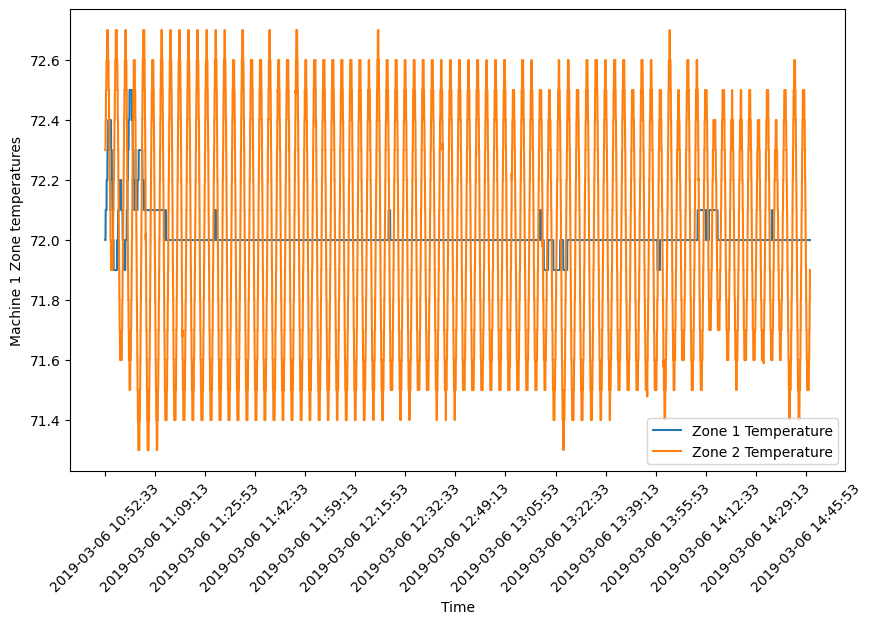

In [12]:
# Machine 1 Zone Temperatures
plt.figure(figsize=(10,6))
plt.plot(resampled_data.index, resampled_data['Machine1.Zone1Temperature.C.Actual'], label = 'Zone 1 Temperature')
plt.plot(resampled_data.index, resampled_data['Machine1.Zone2Temperature.C.Actual'], label = 'Zone 2 Temperature')
plt.xlabel("Time")
plt.ylabel('Machine 1 Zone temperatures')
plt.xticks(ticks=resampled_data.index[::1000], labels=resampled_data.index[::1000], rotation=45)
plt.legend()
plt.show()

Machine 1 has some irregularities in zone 1 temperature but for zone 2 it seems there is a constant fluctuating difference in the temperature.

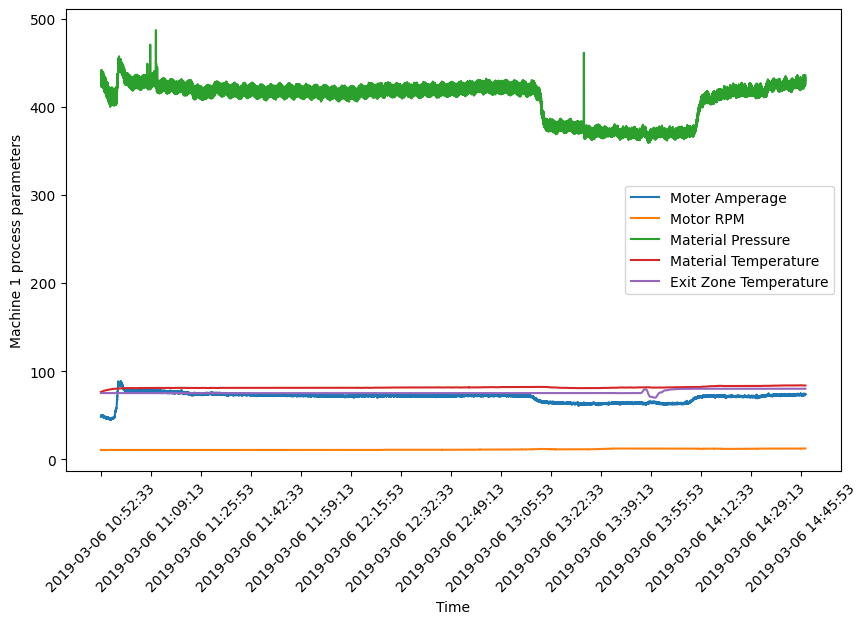

In [13]:
# Machine 1 process parameters
plt.figure(figsize=(10,6))
plt.plot(resampled_data.index, resampled_data['Machine1.MotorAmperage.U.Actual'], label = 'Moter Amperage')
plt.plot(resampled_data.index, resampled_data['Machine1.MotorRPM.C.Actual'], label = 'Motor RPM')
plt.plot(resampled_data.index, resampled_data['Machine1.MaterialPressure.U.Actual'], label = 'Material Pressure')
plt.plot(resampled_data.index, resampled_data['Machine1.MaterialTemperature.U.Actual'], label = 'Material Temperature')
plt.plot(resampled_data.index, resampled_data['Machine1.ExitZoneTemperature.C.Actual'], label = 'Exit Zone Temperature')
plt.xlabel("Time")
plt.ylabel('Machine 1 process parameters')
plt.xticks(ticks=resampled_data.index[::1000], labels=resampled_data.index[::1000],rotation=45)
plt.legend()
plt.show()

There is a dip in material pressure and motor amperage towards the end. 

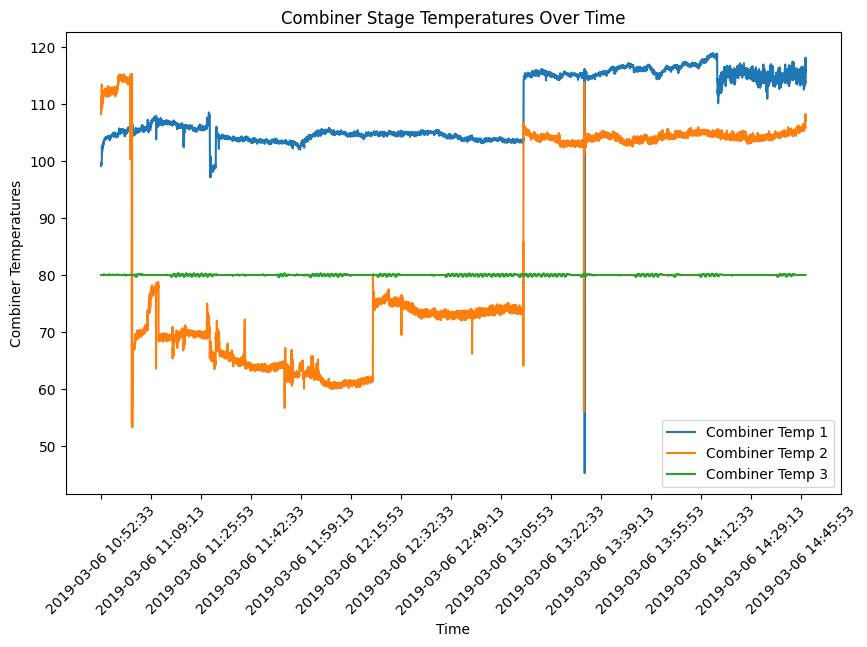

In [14]:
# Visualize first stage combiner stage process variables

plt.figure(figsize=(10,6))
plt.plot(resampled_data.index, resampled_data['FirstStage.CombinerOperation.Temperature1.U.Actual'], label='Combiner Temp 1')
plt.plot(resampled_data.index, resampled_data['FirstStage.CombinerOperation.Temperature2.U.Actual'], label='Combiner Temp 2')
plt.plot(resampled_data.index, resampled_data['FirstStage.CombinerOperation.Temperature3.C.Actual'], label='Combiner Temp 3')
plt.xlabel('Time')
plt.ylabel('Combiner Temperatures')
plt.title('Combiner Stage Temperatures Over Time')
plt.legend()
plt.xticks(ticks=resampled_data.index[::1000], labels=resampled_data.index[::1000],rotation=45)
plt.show()

Combiner stage temperature 1 and 2 have variations whereas temperature 3 seems consistent.

Now that we have an idea of machine 1's input features, let's visualize the a few of the measurements of stage 1 output.

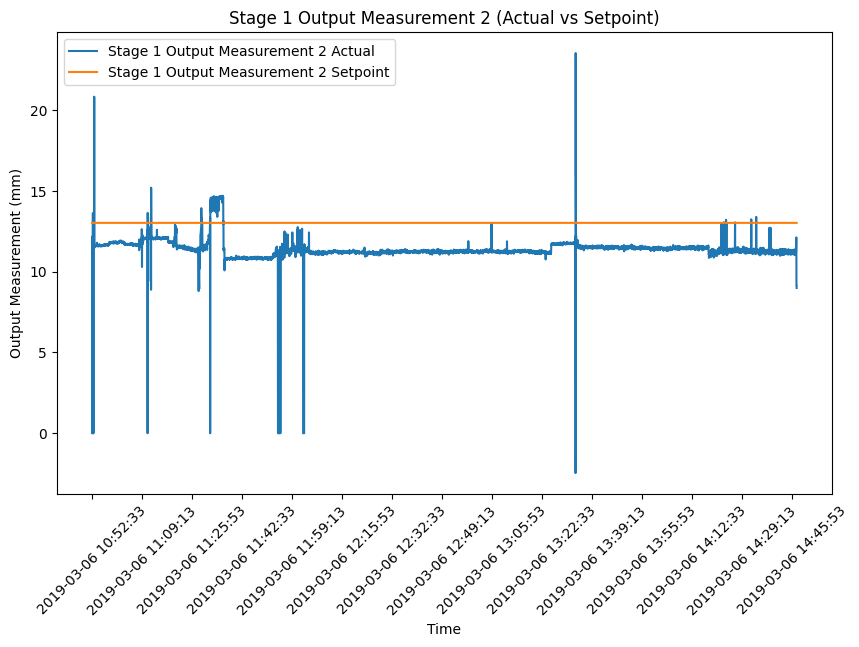

In [15]:
# Plot Stage 1 Output Measurements

plt.figure(figsize=(10,6))
plt.plot(resampled_data.index, resampled_data['Stage1.Output.Measurement2.U.Actual'], label='Stage 1 Output Measurement 2 Actual')
plt.plot(resampled_data.index, resampled_data['Stage1.Output.Measurement2.U.Setpoint'], label='Stage 1 Output Measurement 2 Setpoint')
plt.xlabel('Time')
plt.ylabel('Output Measurement (mm)')
plt.title('Stage 1 Output Measurement 2 (Actual vs Setpoint)')
plt.legend()
plt.xticks(ticks=resampled_data.index[::1000], labels=resampled_data.index[::1000],rotation=45)
plt.show()

From the Stage 1 output measurement plots, we can see that the measurements deviate heavily at some points relative to setpoints. These points could qualify as anomalies. In the next steps, we will perform anomaly detection.

### Anomaly Detection

We have setpoint values for all 15 measurements for both stage 1 and stage 2. Therefore, we will perform threshold sensitivity analysis by labeling the values as outliers that are above the range of +/-10% of the setpoint measurement.

In [16]:
# Columns that represent actual and setpoint values for Stage 1 and Stage 2
stage1_actual_cols = [col for col in resampled_data.columns if 'Stage1.Output.Measurement' in col and 'U.Actual' in col]
stage1_setpoint_cols = [col for col in resampled_data.columns if 'Stage1.Output.Measurement' in col and 'U.Setpoint' in col]
stage2_actual_cols = [col for col in resampled_data.columns if 'Stage2.Output.Measurement' in col and 'U.Actual' in col]
stage2_setpoint_cols = [col for col in resampled_data.columns if 'Stage2.Output.Measurement' in col and 'U.Setpoint' in col]

# Create new column that indicates presence of anomalies based on the given threshold
for i in range(len(stage1_setpoint_cols)):
    resampled_data[f'{stage1_actual_cols[i]}_anomaly'] = (
        (resampled_data[stage1_actual_cols[i]] < resampled_data[stage1_setpoint_cols[i]] * 0.9) | 
        (resampled_data[stage1_actual_cols[i]] > resampled_data[stage1_setpoint_cols[i]] * 1.1)
    ).astype(int) 

for i in range(len(stage2_setpoint_cols)):
    resampled_data[f'{stage2_actual_cols[i]}_anomaly'] = (
        (resampled_data[stage2_actual_cols[i]] < resampled_data[stage2_setpoint_cols[i]] * 0.9) | 
        (resampled_data[stage2_actual_cols[i]] > resampled_data[stage2_setpoint_cols[i]] * 1.1)
    ).astype(int)  

resampled_data_with_anomalies = resampled_data.copy()

In [17]:
resampled_data_with_anomalies.to_csv("processed_data.csv")

We have identified the anomalies in the dataset for the output measurements and labeled them as (0=not anomaly, 1=anomaly).
The anomalies could be present in the measurement values because of several reasons such as machine breakdown, sensor malfunctioning, non-readable measurements etc. For the purpose of this analysis, we will consider the presence of anomalies to indicate downtime of the process.

### Downtime Analysis

After identifying anomalies, we will perform downtime analysis. 
We will create Threshold-based downtime indicators based on majority rule (8 out of 15 measurements are anomaly=downtime)

The downtime indicators will be created for both stage 1 and stage 2 separately.



In [18]:
# Creating Downtime indicator column
resampled_data_with_ano = resampled_data_with_anomalies.reset_index(drop=False)

# Select anomaly columns for Stage 1 & Stage 2 deviations (actuals)
stage1_anomaly_columns = [col for col in resampled_data_with_ano.columns if 'Stage1.Output.Measurement' in col and '_anomaly' in col]
stage2_anomaly_columns = [col for col in resampled_data_with_ano.columns if 'Stage2.Output.Measurement' in col and '_anomaly' in col]

# Define the majority rule threshold
majority_threshold_stage1 = 8
majority_threshold_stage2 = 8

# Create a downtime indicator: 1 if any anomaly in Stage 1/2 output measurement deviations, 0 otherwise
resampled_data_with_ano['stage1_downtime_indicator'] = (resampled_data_with_ano[stage1_anomaly_columns].sum(axis=1) >= majority_threshold_stage1).astype(int)
resampled_data_with_ano['stage2_downtime_indicator'] = (resampled_data_with_ano[stage2_anomaly_columns].sum(axis=1) >= majority_threshold_stage2).astype(int)

resampled_data_with_ano.head()

,time_stamp,AmbientConditions.AmbientHumidity.U.Actual,AmbientConditions.AmbientTemperature.U.Actual,Machine1.RawMaterial.Property1,Machine1.RawMaterial.Property2,Machine1.RawMaterial.Property3,Machine1.RawMaterial.Property4,Machine1.RawMaterialFeederParameter.U.Actual,Machine1.Zone1Temperature.C.Actual,Machine1.Zone2Temperature.C.Actual,...,Stage2.Output.Measurement7.U.Actual_anomaly,Stage2.Output.Measurement8.U.Actual_anomaly,Stage2.Output.Measurement9.U.Actual_anomaly,Stage2.Output.Measurement10.U.Actual_anomaly,Stage2.Output.Measurement11.U.Actual_anomaly,Stage2.Output.Measurement12.U.Actual_anomaly,Stage2.Output.Measurement13.U.Actual_anomaly,Stage2.Output.Measurement14.U.Actual_anomaly,stage1_downtime_indicator,stage2_downtime_indicator
0,2019-03-06 10:52:33,17.24,23.53,11.54,200.0,963.0,247.0,1241.26,72.0,72.3,...,1,1,1,1,1,1,1,1,1,1
1,2019-03-06 10:52:34,17.24,23.53,11.54,200.0,963.0,247.0,1246.09,72.0,72.3,...,1,1,1,1,1,1,1,1,1,1
2,2019-03-06 10:52:35,17.24,23.53,11.54,200.0,963.0,247.0,1246.29,72.0,72.3,...,1,1,1,1,1,1,1,1,1,1
3,2019-03-06 10:52:36,17.24,23.53,11.54,200.0,963.0,247.0,1247.59,72.0,72.3,...,1,1,1,1,1,1,1,1,1,1
4,2019-03-06 10:52:37,17.24,23.53,11.54,200.0,963.0,247.0,1252.83,72.1,72.4,...,1,1,1,1,1,1,1,1,1,1


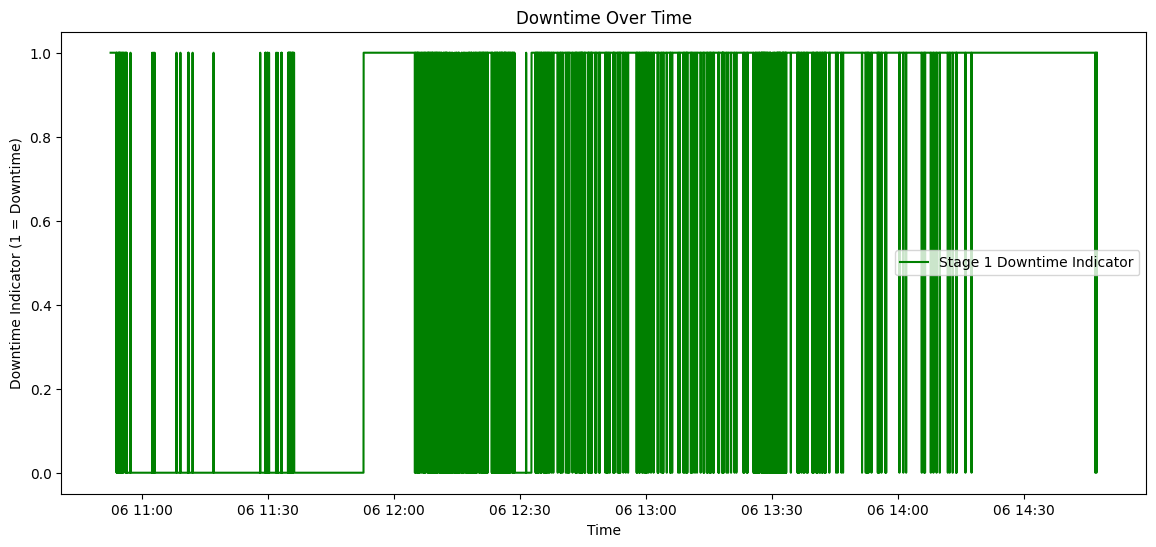

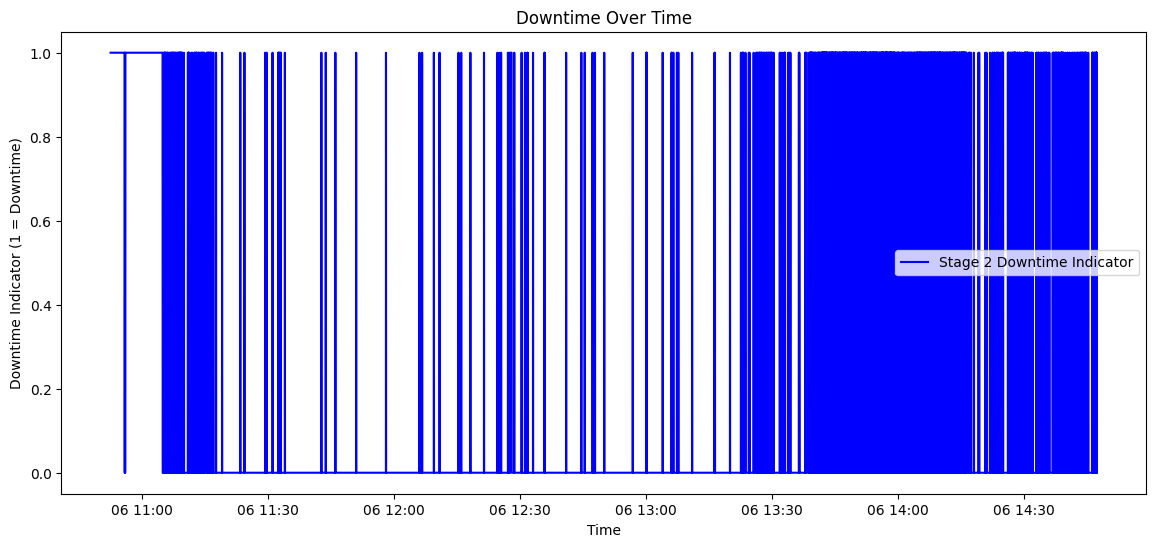

In [19]:
# Plotting downtime over time
plt.figure(figsize=(14,6))
plt.plot(resampled_data_with_ano['time_stamp'], resampled_data_with_ano['stage1_downtime_indicator'], label='Stage 1 Downtime Indicator', color = 'green')
plt.title('Downtime Over Time')
plt.xlabel('Time')
plt.ylabel('Downtime Indicator (1 = Downtime)')
plt.legend()
plt.show()

plt.figure(figsize=(14,6))
plt.plot(resampled_data_with_ano['time_stamp'], resampled_data_with_ano['stage2_downtime_indicator'], label='Stage 2 Downtime Indicator', color = 'blue')
plt.title('Downtime Over Time')
plt.xlabel('Time')
plt.ylabel('Downtime Indicator (1 = Downtime)')
plt.legend()
plt.show()

It is interesting to see that stage 1 and stage 2 do not have same downtimes. Now we will calculate this downtime in `seconds`.

In [72]:
# Stage 1 downtimes
# Calculate downtime duration for Stage 1
downtime_events_stage1 = resampled_data_with_ano[resampled_data_with_ano['stage1_downtime_indicator'] == 1].copy()

# Identify new downtime events by checking time gaps larger than 1 second
downtime_start_times_stage1 = downtime_events_stage1['time_stamp'].diff() > pd.Timedelta('1s')

# Create a new column for downtime events using cumulative sum
downtime_events_stage1.loc[:, 'downtime_event_stage1'] = downtime_start_times_stage1.cumsum()

# Group by downtime events to calculate start and end times for each event
downtime_durations_stage1 = resampled_data_with_ano[resampled_data_with_ano['stage1_downtime_indicator'] == 1].groupby('downtime_event_stage1')['time_stamp'].agg(['min', 'max'])

# Calculate downtime duration in seconds 
downtime_durations_stage1['duration_seconds'] = (downtime_durations_stage1['max'] - downtime_durations_stage1['min']).dt.total_seconds()

# Merge the downtime event information back into the original dataframe
resampled_data_with_ano = pd.merge(resampled_data_with_ano, downtime_events_stage1[['time_stamp', 'downtime_event_stage1']], on='time_stamp', how='left')

# Stage 2 downtimes
# Calculate downtime duration for Stage 2
downtime_events_stage2 = resampled_data_with_ano[resampled_data_with_ano['stage2_downtime_indicator'] == 1].copy()

# Identify new downtime events by checking time gaps larger than 1 second
downtime_start_times_stage2 = downtime_events_stage2['time_stamp'].diff() > pd.Timedelta('1s')

# Create a new column for downtime events
downtime_events_stage2.loc[:, 'downtime_event_stage2'] = downtime_start_times_stage2.cumsum()

# Group by downtime events to calculate start and end times for each event (Stage 2)
downtime_durations_stage2 = resampled_data_with_ano[resampled_data_with_ano['stage2_downtime_indicator'] == 1].groupby('downtime_event_stage2')['time_stamp'].agg(['min', 'max'])

# Calculate downtime duration in seconds (Stage 2)
downtime_durations_stage2['duration_seconds'] = (downtime_durations_stage2['max'] - downtime_durations_stage2['min']).dt.total_seconds()

# Merge the downtime event information back into the original dataframe
resampled_data_with_ano = pd.merge(resampled_data_with_ano, downtime_events_stage2[['time_stamp', 'downtime_event_stage2']], on='time_stamp', how='left')

# Save the updated dataframe with downtime event columns
resampled_data_with_ano.to_csv('processed_data_with_downtime.csv', index=False)

print(downtime_durations_stage1)
print(downtime_durations_stage2)


                                      min                 max  \
downtime_event_stage1                                           
0.0                   2019-03-06 10:52:33 2019-03-06 10:53:57   
1.0                   2019-03-06 10:54:00 2019-03-06 10:54:01   
2.0                   2019-03-06 10:54:05 2019-03-06 10:54:06   
3.0                   2019-03-06 10:54:20 2019-03-06 10:54:26   
4.0                   2019-03-06 10:54:30 2019-03-06 10:54:31   
...                                   ...                 ...   
392.0                 2019-03-06 14:13:56 2019-03-06 14:16:00   
393.0                 2019-03-06 14:16:03 2019-03-06 14:17:27   
394.0                 2019-03-06 14:17:30 2019-03-06 14:46:55   
395.0                 2019-03-06 14:46:58 2019-03-06 14:47:11   
396.0                 2019-03-06 14:47:14 2019-03-06 14:47:20   

                       duration_seconds  
downtime_event_stage1                    
0.0                                84.0  
1.0                         

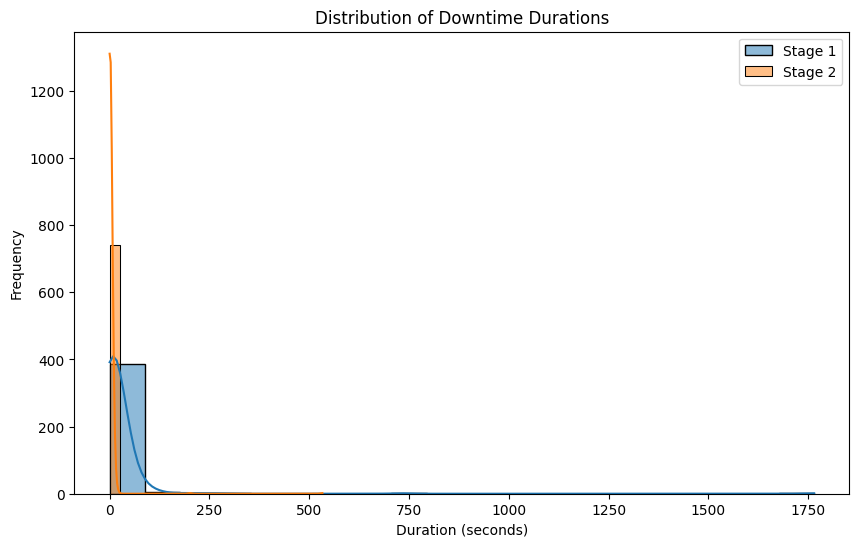

In [21]:
# Histogram of downtime durations
plt.figure(figsize=(10, 6))
sns.histplot(downtime_durations_stage1['duration_seconds'], label = 'Stage 1', bins=20, kde=True)
sns.histplot(downtime_durations_stage2['duration_seconds'], label = 'Stage 2', bins=20, kde=True)
plt.title('Distribution of Downtime Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Above histogram shows that the stage 1 has more frequent and shorter downtimes as compared to that of stage 2. This is also confirmed by the time series plot of downtime events.

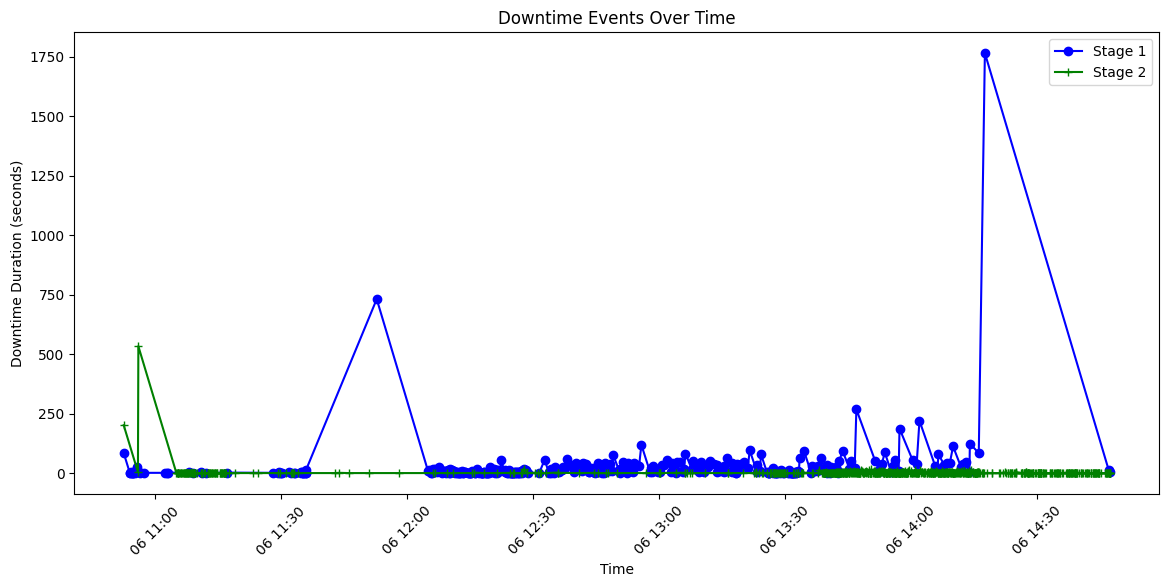

In [22]:
# Plotting downtime events over time
plt.figure(figsize=(14, 6))
plt.plot(downtime_durations_stage1['min'], downtime_durations_stage1['duration_seconds'], marker='o', label = 'Stage 1', linestyle='-', color='b')
plt.plot(downtime_durations_stage2['min'], downtime_durations_stage2['duration_seconds'], marker='+', label = 'Stage 2', linestyle='-', color='g')
plt.title('Downtime Events Over Time')
plt.xlabel('Time')
plt.ylabel('Downtime Duration (seconds)')
plt.xticks(rotation=45)
plt.legend()
plt.show()


Now, we will visualize the Stage 1 and Stage 2 measurements with anomalies during the downtime.

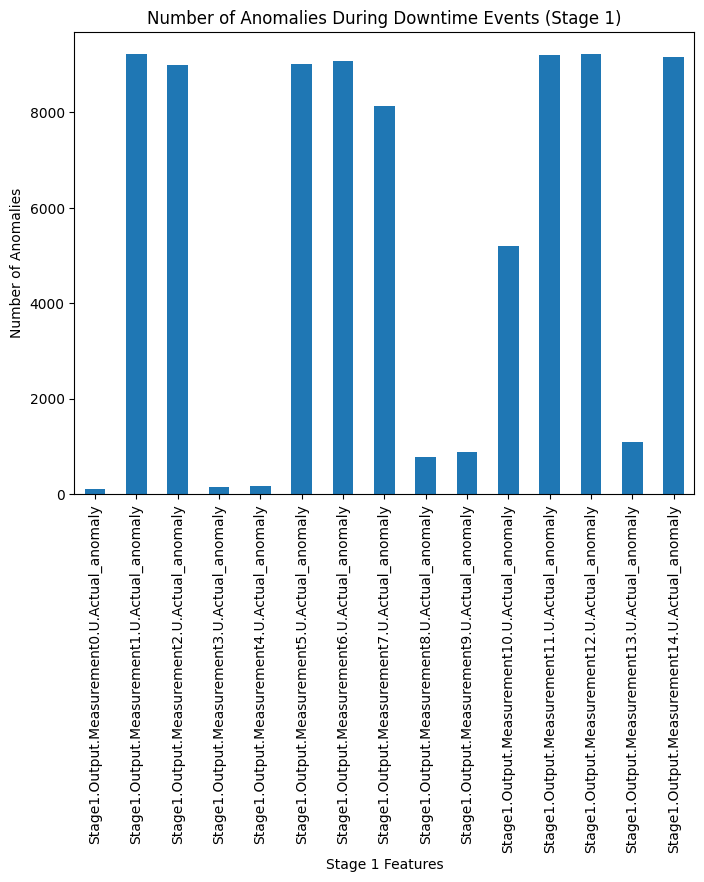

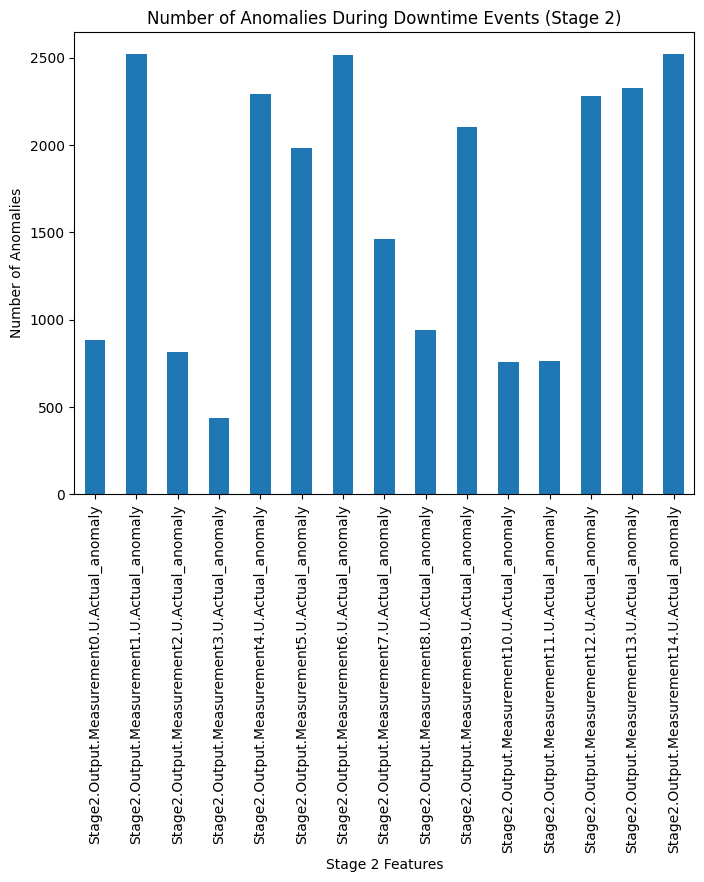

In [23]:
# Count anomalies in each downtime period for Stage 1
anomalous_columns_stage1 = [col for col in resampled_data_with_ano.columns if '_anomaly' in col and 'Stage1' in col]

# Summing anomalies for each downtime event for Stage 1
downtime_anomalies_stage1 = resampled_data_with_ano.loc[resampled_data_with_ano['stage1_downtime_indicator'] == 1, anomalous_columns_stage1].sum()

# Plotting the anomalies during downtime for Stage 1
plt.figure(figsize=(8, 6))
downtime_anomalies_stage1.plot(kind='bar')
plt.title('Number of Anomalies During Downtime Events (Stage 1)')
plt.ylabel('Number of Anomalies')
plt.xlabel('Stage 1 Features')
plt.xticks(rotation=90)
plt.show()

# Count anomalies in each downtime period for Stage 2
anomalous_columns_stage2 = [col for col in resampled_data_with_ano.columns if '_anomaly' in col and 'Stage2' in col]

# Summing anomalies for each downtime event for Stage 2
downtime_anomalies_stage2 = resampled_data_with_ano.loc[resampled_data_with_ano['stage2_downtime_indicator'] == 1, anomalous_columns_stage2].sum()

# Plotting the anomalies during downtime for Stage 2
plt.figure(figsize=(8, 6))
downtime_anomalies_stage2.plot(kind='bar')
plt.title('Number of Anomalies During Downtime Events (Stage 2)')
plt.ylabel('Number of Anomalies')
plt.xlabel('Stage 2 Features')
plt.xticks(rotation=90)
plt.show()


### Predictive modeling for Downtime

Now that we have identified the anomalies and calculated the downtime based on that, we can build predictive models that can forecast unplanned downtimes based on the input features. For this purpose, we will first separate out relevant features for stage 1 and 2 respectively followed by splitting and standardizing.

In [24]:
# Capture Stage 1/2 downtime predictors
stage1_feature_indices = resampled_data_with_ano.iloc[:,1:42]
stage2_feature_indices = resampled_data_with_ano.iloc[:,1:42].join(resampled_data_with_ano.iloc[:,[42,44,46,48,50,52,54,56,58,60,62,64,66,68,70]].join(resampled_data_with_ano.iloc[:,72:86]))
#.join(resampled_data_with_ano.iloc[:,[86,88,90,92,94,96,98,100,102,104,106,108,110,112,114]])

# Split train/test sets
from sklearn.model_selection import train_test_split

X_train_stage1, X_test_stage1, y_train_stage1, y_test_stage1 = train_test_split(stage1_feature_indices, resampled_data_with_ano['stage1_downtime_indicator'], test_size=0.2, random_state=42)
X_train_stage2, X_test_stage2, y_train_stage2, y_test_stage2 = train_test_split(stage2_feature_indices, resampled_data_with_ano['stage2_downtime_indicator'], test_size=0.2, random_state=42)

# Standardize the features for stage 1
scaler = StandardScaler()
X_train_stage1_scaled = scaler.fit_transform(X_train_stage1)
X_test_stage1_scaled = scaler.transform(X_test_stage1)

# Standardize the features for stage 2
X_train_stage2_scaled = scaler.fit_transform(X_train_stage2)
X_test_stage2_scaled = scaler.transform(X_test_stage2)

We have an issue of class imbalance in the dataset with a minority of number of downtimes. Therefore, we will utilize a couple of techniques to handle the class imabalnce issue, such as class weighting and SMOTE (Synthetic Minority Oversampling Technique). We will fit Random Forest classifier and logistic regression with both the techniques in addition to the regular datasets.

Baseline Random Forest Classifier & Logistic Regression with regular standardized dataset

In [59]:
# Baseline Random Forest Classifier with regular standardized dataset
rf_regular = RandomForestClassifier(random_state=42)
rf_regular.fit(X_train_stage1_scaled, y_train_stage1)
rf_regular_pred = rf_regular.predict(X_test_stage1_scaled)

# Baseline Logistic Regression with regular standardized dataset
lg_regular = LogisticRegression(random_state=42)
lg_regular.fit(X_train_stage1_scaled, y_train_stage1)
lg_regular_pred = lg_regular.predict(X_test_stage1_scaled)

# Regular Random Forest results
print("Baseline Random Forest results with regular dataset:")
print(f"Accuracy: {accuracy_score(y_test_stage1, rf_regular_pred)}")
print("Confusion Matrix")
print(confusion_matrix(y_test_stage1, rf_regular_pred))
rf_regular_class_report=classification_report(y_test_stage1, rf_regular_pred, output_dict=True)

# Regular Logistic Regression results
print("Baseline Logistic Regression results with regular dataset:")
print(f"Accuracy: {accuracy_score(y_test_stage1, lg_regular_pred)}")
print("Confusion Matrix")
print(confusion_matrix(y_test_stage1, lg_regular_pred))
lg_regular_class_report=classification_report(y_test_stage1, lg_regular_pred, output_dict=True)

Baseline Random Forest results with regular dataset:
Accuracy: 0.9205110007097232
Confusion Matrix
[[ 822  153]
 [  71 1772]]
Baseline Logistic Regression results with regular dataset:
Accuracy: 0.8676366217175302
Confusion Matrix
[[ 688  287]
 [  86 1757]]


Random Forest Classifier and Logistic Regression with class weighting

In [61]:
# Class weights: assign more weight to the minority class (downtime = 1)
class_weights = {0: 5, 1: 1}

# Random Forest with class weighting
rf_weighted = RandomForestClassifier(class_weight=class_weights, random_state=42)
rf_weighted.fit(X_train_stage1_scaled, y_train_stage1)
rf_weighted_pred = rf_weighted.predict(X_test_stage1_scaled)

# Logistic Regression with class weighting
lr_weighted = LogisticRegression(class_weight=class_weights, random_state=42)
lr_weighted.fit(X_train_stage1_scaled, y_train_stage1)
lr_weighted_pred = lr_weighted.predict(X_test_stage1_scaled)

# Random Forest Results
print("Random Forest with Class Weighting Results:")
print(f"Accuracy: {accuracy_score(y_test_stage1, rf_weighted_pred)}")
print("Confusion Matrix:")
print(confusion_matrix(y_test_stage1, rf_weighted_pred))
rf_weighted_class_report = classification_report(y_test_stage1, rf_weighted_pred, output_dict=True)

# Logistic Regression Results
print("Logistic Regression with Class Weighting Results:")
print(f"Accuracy: {accuracy_score(y_test_stage1, lr_weighted_pred)}")
print("Confusion Matrix:")
print(confusion_matrix(y_test_stage1, lr_weighted_pred))
lr_weighted_class_report=classification_report(y_test_stage1, lr_weighted_pred, output_dict=True)



Random Forest with Class Weighting Results:
Accuracy: 0.914833215046132
Confusion Matrix:
[[ 798  177]
 [  63 1780]]
Logistic Regression with Class Weighting Results:
Accuracy: 0.7856635911994322
Confusion Matrix:
[[ 924   51]
 [ 553 1290]]


Random Forest Classifier and Logistic Regression with SMOTE resampling

In [62]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_stage1_scaled, y_train_stage1)

# Random Forest with resampled data
rf_smote = RandomForestClassifier(random_state=42)
rf_smote.fit(X_train_resampled, y_train_resampled)
rf_smote_pred = rf_smote.predict(X_test_stage1_scaled)

# Logistic Regression with resampled data
lr_smote = LogisticRegression(random_state=42)
lr_smote.fit(X_train_resampled, y_train_resampled)
lr_smote_pred = lr_smote.predict(X_test_stage1_scaled)

# Random Forest Results with SMOTE
print("Random Forest with SMOTE Results:")
print(f"Accuracy: {accuracy_score(y_test_stage1, rf_smote_pred)}")
print("Confusion Matrix:")
print(confusion_matrix(y_test_stage1, rf_smote_pred))
rf_smote_class_report = classification_report(y_test_stage1, rf_smote_pred, output_dict=True)

# Logistic Regression Results with SMOTE
print("Logistic Regression with SMOTE Results:")
print(f"Accuracy: {accuracy_score(y_test_stage1, lr_smote_pred)}")
print("Confusion Matrix:")
print(confusion_matrix(y_test_stage1, lr_smote_pred))
lr_smote_class_report=classification_report(y_test_stage1, lr_smote_pred, output_dict=True)


Random Forest with SMOTE Results:
Accuracy: 0.9141234918381831
Confusion Matrix:
[[ 824  151]
 [  91 1752]]
Logistic Regression with SMOTE Results:
Accuracy: 0.8598296664300923
Confusion Matrix:
[[ 814  161]
 [ 234 1609]]


Now that we have our baseline models, we will utilize LSTM model that can handle more complex relationships in the dataset.

In [63]:
# Reshape the data for LSTM model
timesteps = 1  
n_features = X_train_stage1_scaled.shape[1]

X_train_lstm = X_train_stage1_scaled.reshape((X_train_stage1_scaled.shape[0], timesteps, n_features // timesteps))
X_test_lstm = X_test_stage1_scaled.reshape((X_test_stage1_scaled.shape[0], timesteps, n_features // timesteps))

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Initialize the LSTM model
model = Sequential()

# Add LSTM layers
model.add(LSTM(units=50, return_sequences=True, input_shape=(timesteps, n_features // timesteps)))
model.add(Dropout(0.2))  
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Add a Dense layer for classification
model.add(Dense(units=1, activation='sigmoid'))  

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the LSTM model
history = model.fit(X_train_lstm, y_train_stage1, epochs=10, batch_size=32, validation_split=0.2)



Epoch 1/10


c:\Users\sne17\anaconda3\envs\predmain\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8198 - loss: 0.4822 - val_accuracy: 0.8696 - val_loss: 0.3045
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8704 - loss: 0.3245 - val_accuracy: 0.8762 - val_loss: 0.2922
Epoch 3/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8771 - loss: 0.3026 - val_accuracy: 0.8802 - val_loss: 0.2823
Epoch 4/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8757 - loss: 0.2899 - val_accuracy: 0.8784 - val_loss: 0.2775
Epoch 5/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8862 - loss: 0.2712 - val_accuracy: 0.8846 - val_loss: 0.2680
Epoch 6/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8820 - loss: 0.2739 - val_accuracy: 0.8904 - val_loss: 0.2649
Epoch 7/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8775 - loss: 0.2764 - val_accuracy: 0.8900 - val_loss: 0.2568
Epoch 8/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8877 - loss: 0.2704 - val_accuracy: 0.9020 - val_

In [64]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_lstm, y_test_stage1)
print(f"LSTM Test Accuracy (without SMOTE): {test_accuracy}")

# Make predictions
y_pred = (model.predict(X_test_lstm) > 0.5).astype(int)

# Generate confusion matrix and classification report
conf_matrix = confusion_matrix(y_test_stage1, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

lstm_class_report = classification_report(y_test_stage1, y_pred, output_dict=True)
print(f"Classification Report:\n{lstm_class_report}")


89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8998 - loss: 0.2469
LSTM Test Accuracy (without SMOTE): 0.893186628818512
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Confusion Matrix:
[[ 770  205]
 [  96 1747]]
Classification Report:
{'0': {'precision': 0.8891454965357968, 'recall': 0.7897435897435897, 'f1-score': 0.8365019011406845, 'support': 975.0}, '1': {'precision': 0.8949795081967213, 'recall': 0.9479110146500271, 'f1-score': 0.9206851119894598, 'support': 1843.0}, 'accuracy': 0.8931866572036906, 'macro avg': {'precision': 0.8920625023662591, 'recall': 0.8688273021968085, 'f1-score': 0.8785935065650721, 'support': 2818.0}, 'weighted avg': {'precision': 0.89296099812951, 'recall': 0.8931866572036906, 'f1-score': 0.891558557490682, 'support': 2818.0}}


In [65]:
# Compare the results

columns = ["Metric", "Baseline RF", "Baseline LG", "RF/class weighting", "LR/class weighting", "RF/SMOTE", "LG/SMOTE", "LSTM"]
results_data = [["Accuracy", accuracy_score(y_test_stage1, rf_regular_pred),accuracy_score(y_test_stage1, lg_regular_pred), accuracy_score(y_test_stage1, rf_weighted_pred), accuracy_score(y_test_stage1, lr_weighted_pred), accuracy_score(y_test_stage1, rf_smote_pred), accuracy_score(y_test_stage1, lr_smote_pred), test_accuracy], ["Confusion Matrix", confusion_matrix(y_test_stage1, rf_regular_pred),confusion_matrix(y_test_stage1, lg_regular_pred), confusion_matrix(y_test_stage1, rf_weighted_pred), confusion_matrix(y_test_stage1, lr_weighted_pred), confusion_matrix(y_test_stage1, rf_smote_pred), confusion_matrix(y_test_stage1, lr_smote_pred), conf_matrix], ["Precision", rf_regular_class_report['1']['precision'], lg_regular_class_report['1']['precision'], rf_weighted_class_report['1']['precision'], lr_weighted_class_report['1']['precision'], rf_smote_class_report['1']['precision'], lr_smote_class_report['1']['precision'], lstm_class_report['1']['precision']], ["Recall", rf_regular_class_report['1']['recall'], lg_regular_class_report['1']['recall'], rf_weighted_class_report['1']['recall'], lr_weighted_class_report['1']['recall'], rf_smote_class_report['1']['recall'], lr_smote_class_report['1']['recall'], lstm_class_report['1']['recall']]]

results = pd.DataFrame(data=results_data, columns=columns)
print("Classification metrics for predicting downtime (class=1)")
results


Classification metrics for predicting downtime (class=1)


,Metric,Baseline RF,Baseline LG,RF/class weighting,LR/class weighting,RF/SMOTE,LG/SMOTE,LSTM
0,Accuracy,0.920511,0.867637,0.914833,0.785664,0.914123,0.85983,0.893187
1,Confusion Matrix,"[[822, 153], [71, 1772]]","[[688, 287], [86, 1757]]","[[798, 177], [63, 1780]]","[[924, 51], [553, 1290]]","[[824, 151], [91, 1752]]","[[814, 161], [234, 1609]]","[[770, 205], [96, 1747]]"
2,Precision,0.920519,0.859589,0.909555,0.961969,0.920652,0.90904,0.89498
3,Recall,0.961476,0.953337,0.965817,0.699946,0.950624,0.873033,0.947911


Our baseline model Random Forest with regular dataset performs the best so far based on its precision and recall values.
The model correctly predicts the downtime 92% of the time and the model correctly identifed 96% of all downtime events.

So we will move forward with this model.

Let us look at the feature importance resulting from the baseline models.

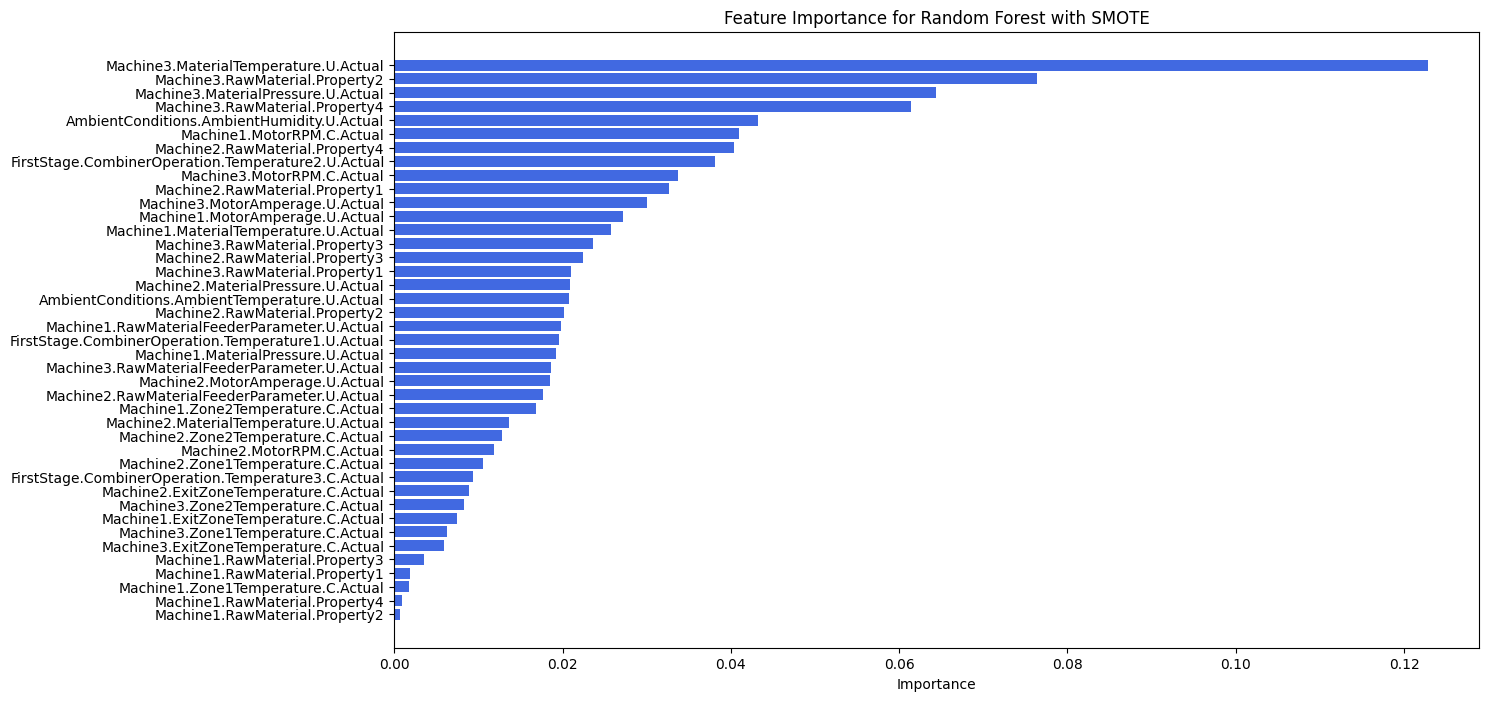

,Feature,Importance
36,Machine3.MaterialTemperature.U.Actual,0.122791
27,Machine3.RawMaterial.Property2,0.076336
35,Machine3.MaterialPressure.U.Actual,0.064401
29,Machine3.RawMaterial.Property4,0.061389
0,AmbientConditions.AmbientHumidity.U.Actual,0.043172
10,Machine1.MotorRPM.C.Actual,0.040979
17,Machine2.RawMaterial.Property4,0.040333
39,FirstStage.CombinerOperation.Temperature2.U.Ac...,0.038099
34,Machine3.MotorRPM.C.Actual,0.033759
14,Machine2.RawMaterial.Property1,0.032636


In [99]:
# Get feature importances from the trained model
feature_importances = rf_regular.feature_importances_

# Create a DataFrame to hold feature names and their importance values
feature_names = X_train_stage1.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(14, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='royalblue')
plt.xlabel('Importance')
plt.title('Feature Importance for Random Forest with SMOTE')
plt.gca().invert_yaxis()  # Invert axis to have the most important features on top
plt.show()

# Print top 10 important features
importance_df.head(10)


### Fine-tuning the model (Stage 1)

In this step, I performed the hyperparamter fine-tuning for the Random Forest model with SMOTE technique. From there, I obtained the best parameters the provide the optimized predictions for the Stage 1 downtime.

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best Parameters: {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Confusion Matrix:
[[ 821  154]
 [  73 1770]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.84      0.88       975
           1       0.92      0.96      0.94      1843

    accuracy                           0.92      2818
   macro avg       0.92      0.90      0.91      2818
weighted avg       0.92      0.92      0.92      2818



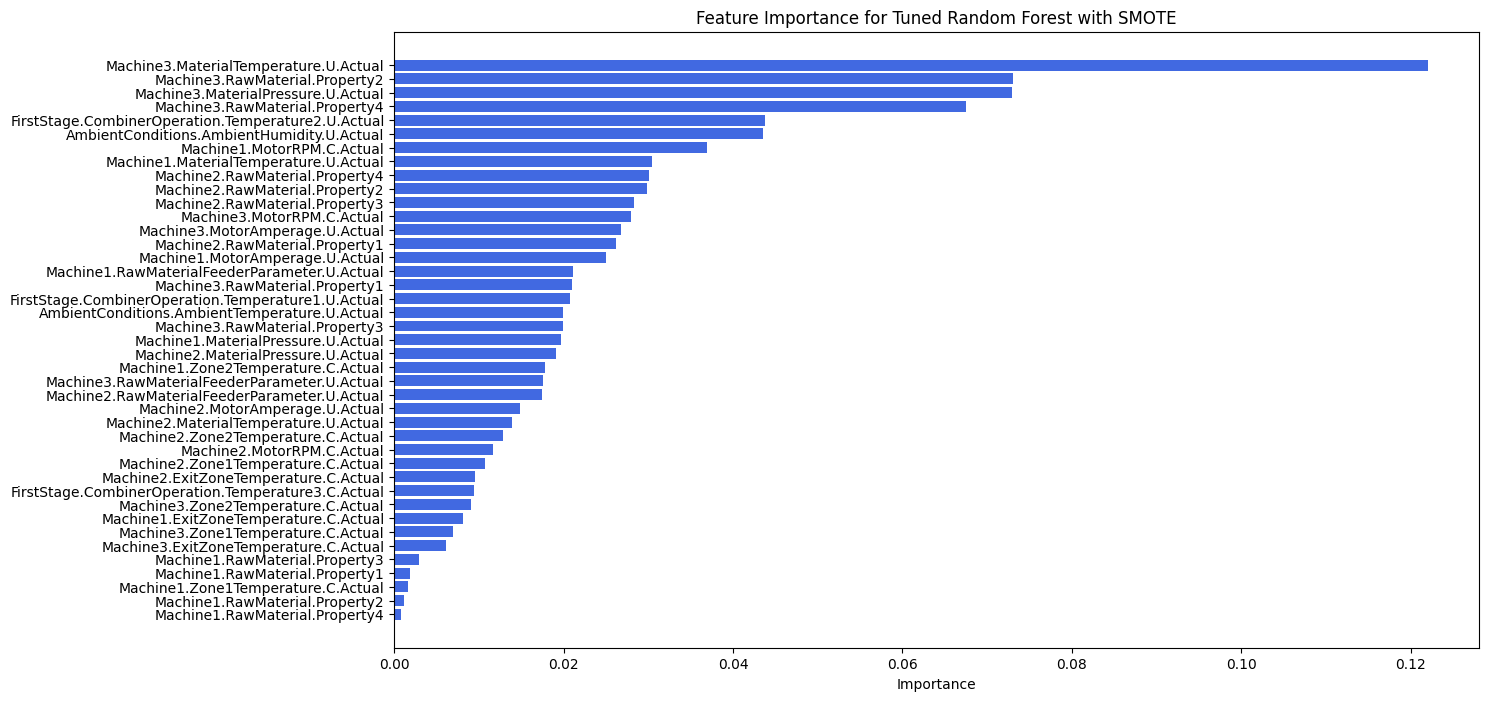

In [100]:
# Set up the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# best parameters
#param_grid = {
#    'n_estimators': [200],
#    'max_depth': [30],
#    'min_samples_split': [2],
#    'min_samples_leaf': [1],
#    'bootstrap': [False]
#}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf_regular, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='f1')

# Fit the grid search model with resampled data
grid_search.fit(X_train_stage1_scaled, y_train_stage1)

# Get the best parameters and results
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")

# Evaluate the tuned model on test data
y_pred = best_rf_model.predict(X_test_stage1_scaled)

# Print classification report and confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test_stage1, y_pred))
print("Classification Report:")
print(classification_report(y_test_stage1, y_pred))

# Feature importance from the best model
feature_importances = best_rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train_stage1.columns, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(14, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='royalblue')
plt.xlabel('Importance')
plt.title('Feature Importance for Tuned Random Forest')
plt.gca().invert_yaxis()
plt.show()

#Best Parameters: {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

In [38]:
resampled_data_with_ano['stage2_downtime_indicator'].value_counts()[0]

11567

### Fine-tuning the model (Stage 2)

Similarly, I performed the hyperparameter tuning for the Random Forest model to obtain optimized predictions for stage 2 downtime.

In [52]:
# Baseline Random Forest Classifier with regular standardized dataset
rf_regular2 = RandomForestClassifier(random_state=42)
rf_regular2.fit(X_train_stage2_scaled, y_train_stage2)
rf_regular_pred2 = rf_regular2.predict(X_test_stage2_scaled)

# Baseline Logistic Regression with regular standardized dataset
lg_regular2 = LogisticRegression(random_state=42, max_iter=1000)
lg_regular2.fit(X_train_stage2_scaled, y_train_stage2)
lg_regular_pred2 = lg_regular2.predict(X_test_stage2_scaled)

# Regular Random Forest results
print("Baseline Random Forest results with regular dataset:")
print(f"Accuracy: {accuracy_score(y_test_stage2, rf_regular_pred2)}")
print("Confusion Matrix")
print(confusion_matrix(y_test_stage2, rf_regular_pred2))
rf_regular_class_report2=classification_report(y_test_stage2, rf_regular_pred2, output_dict=True)

# Regular Logistic Regression results
print("Baseline Logistic Regression results with regular dataset:")
print(f"Accuracy: {accuracy_score(y_test_stage2, lg_regular_pred2)}")
print("Confusion Matrix")
print(confusion_matrix(y_test_stage2, lg_regular_pred2))
lg_regular_class_report2=classification_report(y_test_stage2, lg_regular_pred2, output_dict=True)

Baseline Random Forest results with regular dataset:
Accuracy: 0.896735273243435
Confusion Matrix
[[2185  106]
 [ 185  342]]
Baseline Logistic Regression results with regular dataset:
Accuracy: 0.8924769339957417
Confusion Matrix
[[2168  123]
 [ 180  347]]


In [53]:
# Class weights: assign more weight to the minority class (downtime = 1)
class_weights = {0: 1, 1: 8}

# Random Forest with class weighting
rf_weighted2 = RandomForestClassifier(class_weight=class_weights, random_state=42)
rf_weighted2.fit(X_train_stage2_scaled, y_train_stage2)
rf_weighted_pred2 = rf_weighted2.predict(X_test_stage2_scaled)

# Logistic Regression with class weighting
lr_weighted2 = LogisticRegression(class_weight=class_weights, random_state=42, max_iter=1000)
lr_weighted2.fit(X_train_stage2_scaled, y_train_stage2)
lr_weighted_pred2 = lr_weighted2.predict(X_test_stage2_scaled)

# Random Forest Results
print("Random Forest with Class Weighting Results:")
print(f"Accuracy: {accuracy_score(y_test_stage2, rf_weighted_pred2)}")
print("Confusion Matrix:")
print(confusion_matrix(y_test_stage2, rf_weighted_pred2))
rf_weighted_class_report2 = classification_report(y_test_stage2, rf_weighted_pred2, output_dict=True)

# Logistic Regression Results
print("Logistic Regression with Class Weighting Results:")
print(f"Accuracy: {accuracy_score(y_test_stage2, lr_weighted_pred2)}")
print("Confusion Matrix:")
print(confusion_matrix(y_test_stage2, lr_weighted_pred2))
lr_weighted_class_report2=classification_report(y_test_stage2, lr_weighted_pred2, output_dict=True)



Random Forest with Class Weighting Results:
Accuracy: 0.8949609652235628
Confusion Matrix:
[[2205   86]
 [ 210  317]]
Logistic Regression with Class Weighting Results:
Accuracy: 0.8115684882895671
Confusion Matrix:
[[1833  458]
 [  73  454]]


In [54]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the classes
smote2 = SMOTE(random_state=42)
X_train_resampled2, y_train_resampled2 = smote2.fit_resample(X_train_stage2_scaled, y_train_stage2)

# Random Forest with resampled data
rf_smote2 = RandomForestClassifier(random_state=42)
rf_smote2.fit(X_train_resampled2, y_train_resampled2)
rf_smote_pred2 = rf_smote2.predict(X_test_stage2_scaled)

# Logistic Regression with resampled data
lr_smote2 = LogisticRegression(random_state=42, max_iter=1000)
lr_smote2.fit(X_train_resampled2, y_train_resampled2)
lr_smote_pred2 = lr_smote2.predict(X_test_stage2_scaled)

# Random Forest Results with SMOTE
print("Random Forest with SMOTE Results:")
print(f"Accuracy: {accuracy_score(y_test_stage2, rf_smote_pred2)}")
print("Confusion Matrix:")
print(confusion_matrix(y_test_stage2, rf_smote_pred2))
rf_smote_class_report2 = classification_report(y_test_stage2, rf_smote_pred2, output_dict=True)

# Logistic Regression Results with SMOTE
print("Logistic Regression with SMOTE Results:")
print(f"Accuracy: {accuracy_score(y_test_stage2, lr_smote_pred2)}")
print("Confusion Matrix:")
print(confusion_matrix(y_test_stage2, lr_smote_pred2))
lr_smote_class_report2=classification_report(y_test_stage2, lr_smote_pred2, output_dict=True)


Random Forest with SMOTE Results:
Accuracy: 0.8992193044712562
Confusion Matrix:
[[2141  150]
 [ 134  393]]
Logistic Regression with SMOTE Results:
Accuracy: 0.86124911284599
Confusion Matrix:
[[1998  293]
 [  98  429]]


In [49]:
# Reshape the data for LSTM model
timesteps = 1  
n_features = X_train_stage2_scaled.shape[1]

X_train_lstm2 = X_train_stage2_scaled.reshape((X_train_stage2_scaled.shape[0], timesteps, n_features // timesteps))
X_test_lstm2 = X_test_stage2_scaled.reshape((X_test_stage2_scaled.shape[0], timesteps, n_features // timesteps))

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Initialize the LSTM model
model2 = Sequential()

# Add LSTM layers
model2.add(LSTM(units=50, return_sequences=True, input_shape=(timesteps, n_features // timesteps)))
model2.add(Dropout(0.2))  
model2.add(LSTM(units=50, return_sequences=False))
model2.add(Dropout(0.2))

# Add a Dense layer for classification
model2.add(Dense(units=1, activation='sigmoid'))  

# Compile the model
model2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the LSTM model
history2 = model2.fit(X_train_lstm2, y_train_stage2, epochs=10, batch_size=32, validation_split=0.2)

c:\Users\sne17\anaconda3\envs\predmain\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8483 - loss: 0.4443 - val_accuracy: 0.8820 - val_loss: 0.2594
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9028 - loss: 0.2337 - val_accuracy: 0.8838 - val_loss: 0.2554
Epoch 3/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9046 - loss: 0.2307 - val_accuracy: 0.8842 - val_loss: 0.2529
Epoch 4/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8968 - loss: 0.2381 - val_accuracy: 0.8842 - val_loss: 0.2573
Epoch 5/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9055 - loss: 0.2131 - val_accuracy: 0.8820 - val_loss: 0.2506
Epoch 6/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9055 - loss: 0.2263 - val_accuracy: 0.8829 - val_loss: 0.2544
Epoch 7/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9084 - loss: 0.2237 - val_accuracy: 0.8851 - val_loss: 0.2518
Epoch 8/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9030 - loss: 0.2252 - val_accuracy: 0.

In [50]:
# Evaluate the model on the test set
test_loss2, test_accuracy2 = model2.evaluate(X_test_lstm2, y_test_stage2)
print(f"LSTM Test Accuracy (without SMOTE): {test_accuracy2}")

# Make predictions
y_pred2 = (model2.predict(X_test_lstm2) > 0.5).astype(int)

# Generate confusion matrix and classification report
conf_matrix2 = confusion_matrix(y_test_stage2, y_pred2)
print(f"Confusion Matrix:\n{conf_matrix2}")

lstm_class_report2 = classification_report(y_test_stage2, y_pred2, output_dict=True)
print(f"Classification Report:\n{lstm_class_report2}")


89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9013 - loss: 0.2514
LSTM Test Accuracy (without SMOTE): 0.9013484716415405
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Confusion Matrix:
[[2174  117]
 [ 161  366]]
Classification Report:
{'0': {'precision': 0.9310492505353319, 'recall': 0.9489305979921432, 'f1-score': 0.9399048854301773, 'support': 2291.0}, '1': {'precision': 0.7577639751552795, 'recall': 0.6944971537001897, 'f1-score': 0.7247524752475247, 'support': 527.0}, 'accuracy': 0.9013484740951029, 'macro avg': {'precision': 0.8444066128453057, 'recall': 0.8217138758461664, 'f1-score': 0.832328680338851, 'support': 2818.0}, 'weighted avg': {'precision': 0.8986428133013762, 'recall': 0.9013484740951029, 'f1-score': 0.8996687888488224, 'support': 2818.0}}


In [57]:
# Compare the results

columns2 = ["Metric", "Baseline RF", "Baseline LG", "RF/class weighting", "LR/class weighting", "RF/SMOTE", "LG/SMOTE", "LSTM"]
results_data2 = [["Accuracy", accuracy_score(y_test_stage2, rf_regular_pred2),accuracy_score(y_test_stage2, lg_regular_pred2), accuracy_score(y_test_stage2, rf_weighted_pred2), accuracy_score(y_test_stage2, lr_weighted_pred2), accuracy_score(y_test_stage2, rf_smote_pred2), accuracy_score(y_test_stage2, lr_smote_pred2), test_accuracy2], ["Confusion Matrix", confusion_matrix(y_test_stage2, rf_regular_pred2),confusion_matrix(y_test_stage2, lg_regular_pred2), confusion_matrix(y_test_stage2, rf_weighted_pred2), confusion_matrix(y_test_stage2, lr_weighted_pred2), confusion_matrix(y_test_stage2, rf_smote_pred2), confusion_matrix(y_test_stage2, lr_smote_pred2), conf_matrix2], ["Precision", rf_regular_class_report2['1']['precision'], lg_regular_class_report2['1']['precision'], rf_weighted_class_report2['1']['precision'], lr_weighted_class_report2['1']['precision'], rf_smote_class_report2['1']['precision'], lr_smote_class_report2['1']['precision'], lstm_class_report2['1']['precision']], ["Recall", rf_regular_class_report2['1']['recall'], lg_regular_class_report2['1']['recall'], rf_weighted_class_report2['1']['recall'], lr_weighted_class_report2['1']['recall'], rf_smote_class_report2['1']['recall'], lr_smote_class_report2['1']['recall'], lstm_class_report2['1']['recall']]]

results2 = pd.DataFrame(data=results_data2, columns=columns2)
print("Classification metrics for predicting downtime (class=1)")
results2

Classification metrics for predicting downtime (class=1)


,Metric,Baseline RF,Baseline LG,RF/class weighting,LR/class weighting,RF/SMOTE,LG/SMOTE,LSTM
0,Accuracy,0.896735,0.892477,0.894961,0.811568,0.899219,0.861249,0.901348
1,Confusion Matrix,"[[2185, 106], [185, 342]]","[[2168, 123], [180, 347]]","[[2205, 86], [210, 317]]","[[1833, 458], [73, 454]]","[[2141, 150], [134, 393]]","[[1998, 293], [98, 429]]","[[2174, 117], [161, 366]]"
2,Precision,0.763393,0.738298,0.7866,0.497807,0.723757,0.594183,0.757764
3,Recall,0.648956,0.658444,0.601518,0.86148,0.745731,0.814042,0.694497


Stage 2 model performance is poorer than stage 1 performance because of higher imbalance in class issue in the former.

Random Forest with SMOTE performs the best with precision of 72.4% and recall of 74.6%.

We will tune the Random Forest with SMOTE model to get the optimized parameters for the model.

Fitting 3 folds for each of 162 candidates, totalling 486 fits


c:\Users\sne17\anaconda3\envs\predmain\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters for Stage 2: {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Stage 2 Random Forest with SMOTE (Tuned) Accuracy: 0.8985095812633073
Confusion Matrix:
 [[2148  143]
 [ 143  384]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      2291
           1       0.73      0.73      0.73       527

    accuracy                           0.90      2818
   macro avg       0.83      0.83      0.83      2818
weighted avg       0.90      0.90      0.90      2818



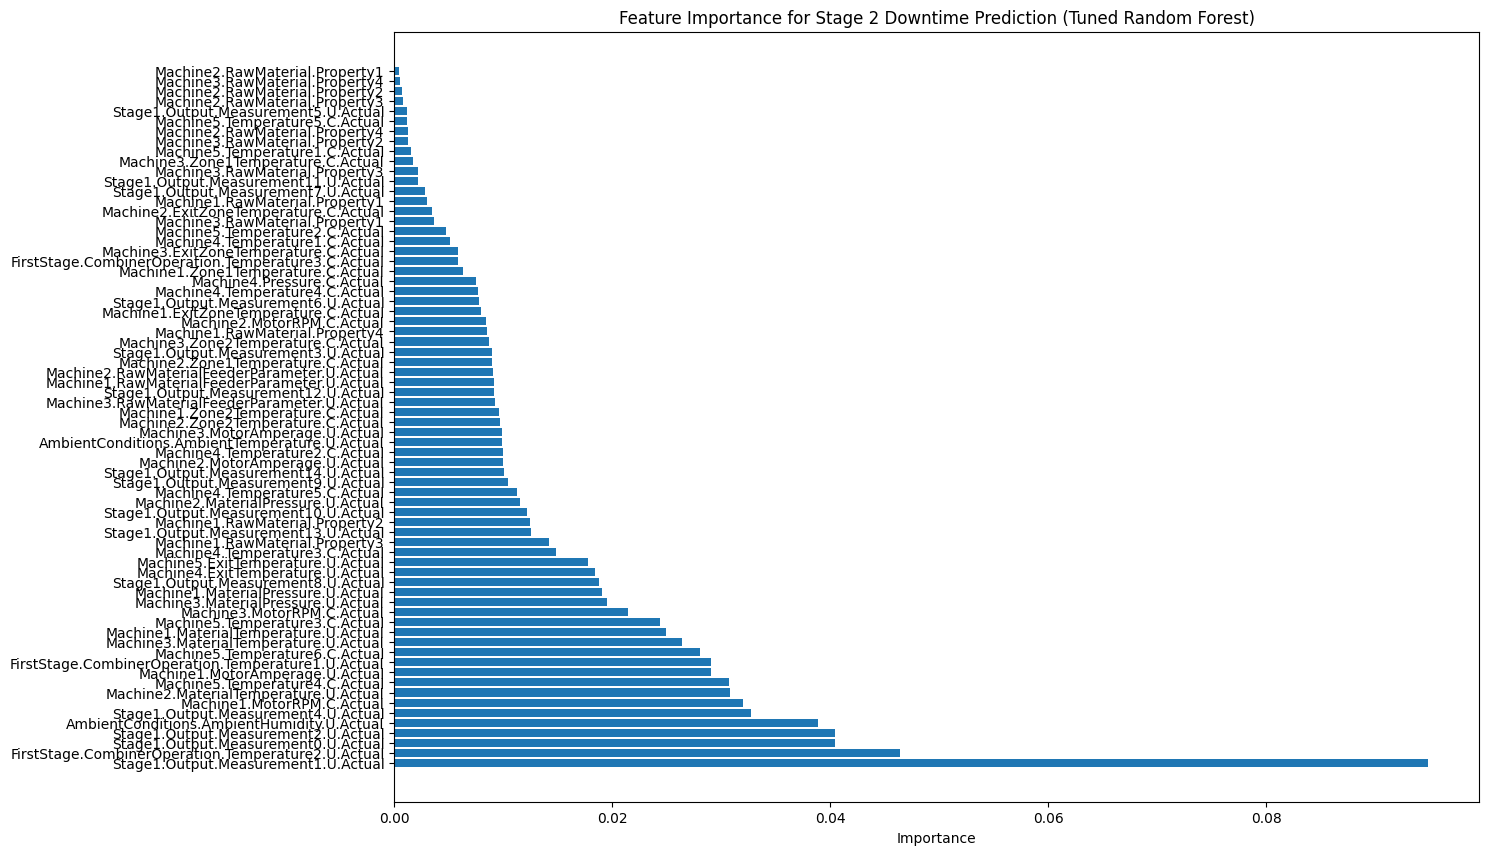

,Feature,Importance
42,Stage1.Output.Measurement1.U.Actual,0.094813
39,FirstStage.CombinerOperation.Temperature2.U.Ac...,0.046439
41,Stage1.Output.Measurement0.U.Actual,0.040463
43,Stage1.Output.Measurement2.U.Actual,0.040405
0,AmbientConditions.AmbientHumidity.U.Actual,0.038845
45,Stage1.Output.Measurement4.U.Actual,0.032751
10,Machine1.MotorRPM.C.Actual,0.032038
24,Machine2.MaterialTemperature.U.Actual,0.030793
66,Machine5.Temperature4.C.Actual,0.030692
9,Machine1.MotorAmperage.U.Actual,0.029079


In [56]:
# Apply SMOTE to balance the classes
smote2 = SMOTE(random_state=42)
X_train_resampled2, y_train_resampled2 = smote2.fit_resample(X_train_stage2_scaled, y_train_stage2)

# Set up the hyperparameter grid
#param_grid_stage2 = {
#    'n_estimators': [100, 200, 300],
#    'max_depth': [10, 20, 30],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4],
#    'bootstrap': [True, False]
#}

# Best hyperparamter
param_grid_stage2 = {
    'n_estimators': [300],
    'max_depth': [30],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'bootstrap': [False]
}

# Initialize the Random Forest model
rf_stage2 = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search_stage2 = GridSearchCV(estimator=rf_stage2, param_grid=param_grid_stage2, cv=3, n_jobs=-1, verbose=2, scoring='f1')

# Fit the grid search model with resampled data
grid_search_stage2.fit(X_train_resampled2, y_train_resampled2)

# Get the best parameters and results
best_params_stage2 = grid_search_stage2.best_params_
best_rf_stage2_model = grid_search_stage2.best_estimator_

print(f"Best Parameters for Stage 2: {best_params_stage2}")

# Predict on test data
y_pred_stage2 = best_rf_stage2_model.predict(X_test_stage2_scaled)

# Evaluate performance
accuracy_stage2 = best_rf_stage2_model.score(X_test_stage2_scaled, y_test_stage2)
print(f"Stage 2 Random Forest with SMOTE (Tuned) Accuracy: {accuracy_stage2}")

# Confusion matrix
conf_matrix_stage2 = confusion_matrix(y_test_stage2, y_pred_stage2)
print("Confusion Matrix:\n", conf_matrix_stage2)

# Classification report
class_report_stage2 = classification_report(y_test_stage2, y_pred_stage2)
print("Classification Report:\n", class_report_stage2)

# Get feature importance for Stage 2
stage2_feature_importance = best_rf_stage2_model.feature_importances_

# Create DataFrame for feature importance
stage2_feature_importance_df = pd.DataFrame({
    'Feature': stage2_feature_indices.columns,
    'Importance': stage2_feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance for Stage 2
plt.figure(figsize=(14, 10))
plt.barh(stage2_feature_importance_df['Feature'], stage2_feature_importance_df['Importance'])
plt.title('Feature Importance for Stage 2 Downtime Prediction (Tuned Random Forest)')
plt.xlabel('Importance')
plt.show()

stage2_feature_importance_df.head(10)

#Best Parameters for Stage 2: {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [68]:
# Save the processed DataFrame to a CSV file
resampled_data_with_ano.to_csv('processed_data.csv', index=False)